#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

# Установка библиотек

In [1]:
!pip install --upgrade scikit-learn --quiet

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

In [2]:
plt.rcParams["figure.figsize"] = (15,10)

## Подготовка данных

In [3]:
try:
  df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv')
except:
  df = pd.read_csv('/datasets/taxi.csv')
df.head(10)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
5,2018-03-01 00:50:00,21
6,2018-03-01 01:00:00,7
7,2018-03-01 01:10:00,5
8,2018-03-01 01:20:00,17
9,2018-03-01 01:30:00,12


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [5]:
df.isna().sum()

datetime      0
num_orders    0
dtype: int64

In [6]:
df['datetime'] = pd.to_datetime(df.datetime)
df = df.set_index('datetime').sort_index()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [7]:
df.tail(10)

,num_orders
datetime,
2018-08-31 22:20:00,48
2018-08-31 22:30:00,41
2018-08-31 22:40:00,34
2018-08-31 22:50:00,34
2018-08-31 23:00:00,30
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39


Вывод: из массива видим, что у нас загружены данные по заказам с марта по сентябрь (невключительно) с интервалом в 10 минут, перевели столбец datetime из объекта в формат времени, назначали этот столбец индексом, пропусков нет.

## Анализ массива данных

### Графики и ресемплирование

Построим график заказов по текущим данным

<AxesSubplot:xlabel='datetime', ylabel='num_orders'>

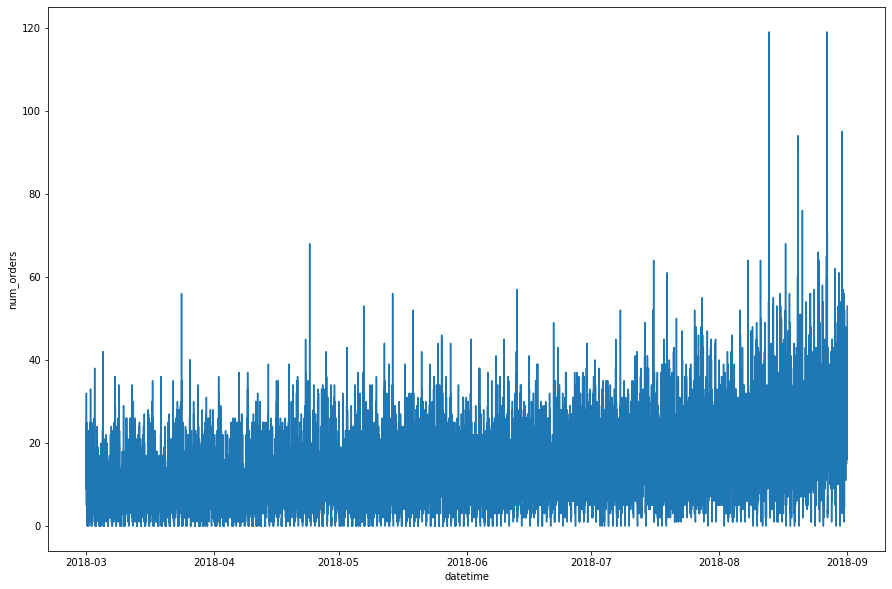

In [8]:
sns.lineplot(x = df.index, y = df['num_orders'])

График читать неудобно, сделаем ресемплирование по 1 часу и напечатаем график

In [9]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<AxesSubplot:xlabel='datetime', ylabel='num_orders'>

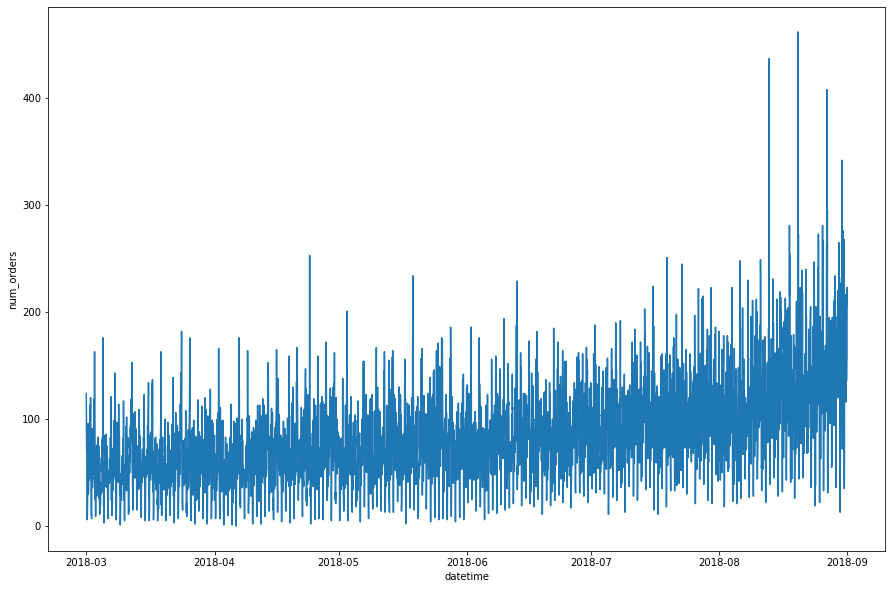

In [10]:
sns.lineplot(x = df.index, y = df['num_orders'])

Ресемплирование не дало большого результата, данные все равно слишком смешаны в "шум", попробуем посчитать скользящее среднее, создадим сезонные столбцы (день, день недели, месяц) и посчитаем "отстающие значения"

### Разделение на тренды и сезонность

In [11]:
decomposed = seasonal_decompose(df) 

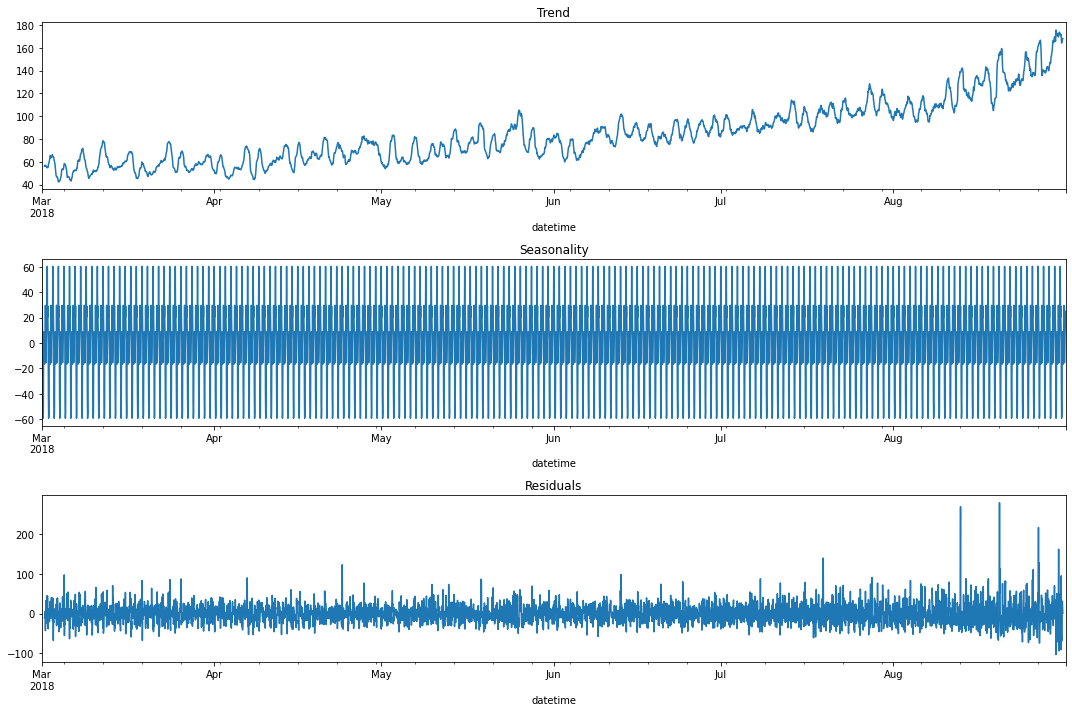

In [12]:
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Text(0.5, 1.0, 'Seasonality')

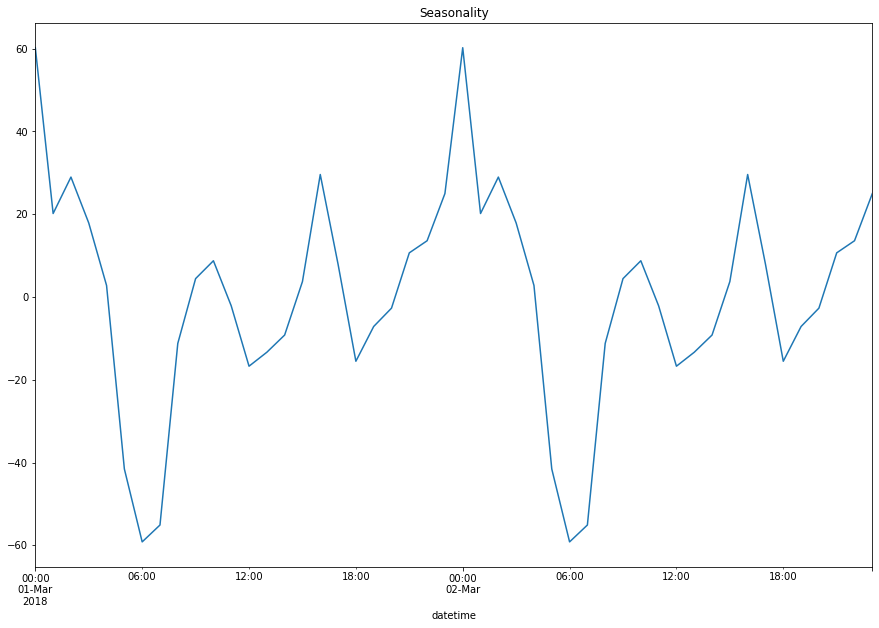

In [13]:
decomposed.seasonal['2018-03-01':'2018-03-2'].plot(ax=plt.gca())
plt.title('Seasonality')

Вывод: из графиков выше видно, что тренд постепенно растет, а сезонность у нас суточная

### Создание дополнительных признаков

Создадим функцию, которая будет принимать на вход кол-во "лагов" и кол-во скользящих средних.

In [14]:
def make_features(data, max_lag, rolling_mean_size):
  new_data = data.copy()
  new_data['day'] = new_data.index.day
  new_data['month'] = new_data.index.month
  new_data['dayofweek'] = new_data.index.dayofweek
  for lag in range(1, max_lag+1):
        new_data['lag_{}'.format(lag)] = new_data['num_orders'].shift(lag)

  new_data['rolling_mean'] = new_data['num_orders'].shift().rolling(rolling_mean_size).mean()
  
  return new_data

## Обучение и тестирование

Все данные результатов будем хранить в таблице-логе + создадим список моделей для обучения

In [20]:
column = ['Модель', 'Гиперпараметры', 'Отстающее значение' ,'Скользящее среднее', 'Метрика RMSE_valid', 'Метрика RMSE_test', 'Время вычисления']
results = pd.DataFrame(columns=column)

In [21]:
models = [
    LinearRegression(),
    RandomForestRegressor(),
    LGBMRegressor(),
]
parameters = [
     {},
     {'n_estimators':[100],
      'max_depth':[17],
     'random_state':[0]
    },
    {'learning_rate' : [0.5],
     'n_estimators':[100],
     'random_state':[0]
    }
]

Создадим функцию расчета rmse метрики для валидационной выборки и для тестовой.
Функция будет создавать новые признаки, обучать модели из списка и предсказывать метрики, вести лог

In [22]:
for lag in range(172, 173):
  for roll in range(68, 69):
    new_df = make_features(df, lag, roll)
    X = new_df.drop('num_orders', axis = 1)
    y = new_df['num_orders']
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)
    X_train = X_train.dropna()
    y_train = y_train[X_train.index]

    for model, param in zip(models, parameters):
      start_time = time.time()
      reg_model = GridSearchCV(model, param_grid = param, scoring = 'neg_root_mean_squared_error', cv = TimeSeriesSplit(n_splits = 3).split(X_train), n_jobs = -1).fit(X_train, y_train)
      reg_model.best_estimator_.fit(X_train, y_train)
      predict_test = reg_model.best_estimator_.predict(X_test)
      rmse_test = mean_squared_error(y_test, predict_test, squared = False)
      count_time = round(time.time() - start_time, 2)
      if rmse_test<48:
        results = pd.concat([results, pd.DataFrame([[model, reg_model.best_params_, lag, roll, -reg_model.best_score_, rmse_test, count_time]], columns = column)])

Для сокращения времени обучения моделей, воспользуюсь заранее просчитанными признаками, выведем на экран наилучшую модель и метрику

In [23]:
display(results)

,Модель,Гиперпараметры,Отстающее значение,Скользящее среднее,Метрика RMSE_valid,Метрика RMSE_test,Время вычисления
0,LinearRegression(),{},172,68,23.212601,35.736418,1.71
0,RandomForestRegressor(),"{'max_depth': 17, 'n_estimators': 100, 'random...",172,68,23.889476,38.773235,73.97
0,LGBMRegressor(),"{'learning_rate': 0.5, 'n_estimators': 100, 'r...",172,68,26.017321,40.771100,3.35


In [24]:
results[results['Метрика RMSE_test']==results['Метрика RMSE_test'].min()]

,Модель,Гиперпараметры,Отстающее значение,Скользящее среднее,Метрика RMSE_valid,Метрика RMSE_test,Время вычисления
0,LinearRegression(),{},172,68,23.212601,35.736418,1.71


Вывод:
Мы провели анализ данных и выявили, что кол-во заказов у компании с каждым месяцем растет и наблюдается ежедневная сезонность заказов. Также мы посчитали RMSE метрику для компании - средняя ошибка составляет 35,7 заказов в час.